# Determining stroke presence using classification models

According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.
T
his dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.

The dataset can be found on Kaggle at https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

### Importing relevant libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

### Reading in the data

In [2]:
stroke = pd.read_csv('/Users/chris/Downloads/healthcare-dataset-stroke-data.csv')
# Display first 5 rows of dataset
stroke.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### Initial Data Exploration

In [3]:
# Display number of rows and columns
stroke.shape

(5110, 12)

The dataset has 5110 rows and 12 columns.

In [4]:
stroke.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


The dataset is made up of a mixture of categorial and continuous columns. We will have to convert the relevant categorical columns to numeric before we proceed with the model implementation.

In [5]:
stroke.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


- The average age recorded in the dataset is 43 years old. The minimum value is 0.08 years, which may be an anomaly.
- The average bmi is ~29, with values ranging from 10 to almost 100.
- Only 0.05% of the dataset has had heart disease.

In [6]:
# Count missing values
stroke.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

The column `bmi` contains some missing values so we will have to deal with these before we build our models.

### Data Visualisation

<Axes: xlabel='stroke', ylabel='count'>

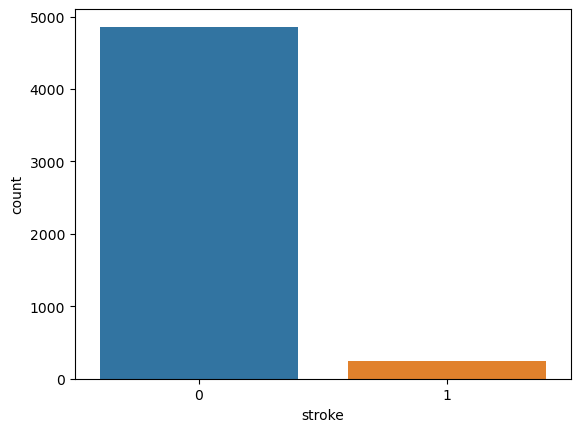

In [7]:
sns.countplot(x = 'stroke', data = stroke)

In [8]:
stroke['stroke'].value_counts()

stroke
0    4861
1     249
Name: count, dtype: int64

Only 249 of the observations in the dataset recorded a stroke. 

<Axes: >

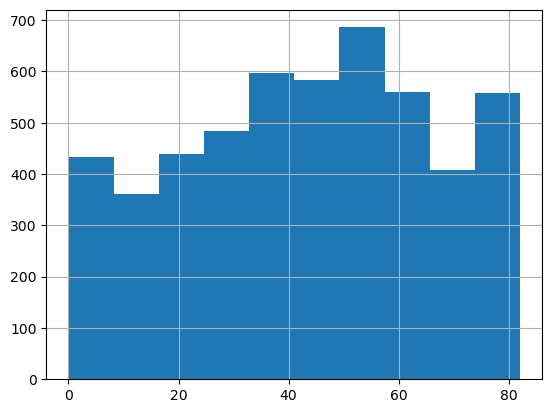

In [9]:
stroke['age'].hist()

In [10]:
stroke['age'].value_counts().sort_index()

age
0.08       2
0.16       3
0.24       5
0.32       5
0.40       2
        ... 
78.00    102
79.00     85
80.00     70
81.00     60
82.00     56
Name: count, Length: 104, dtype: int64

The values below 1 don't seem to be anomalies but rather data collected from infants, based on the spread of values.

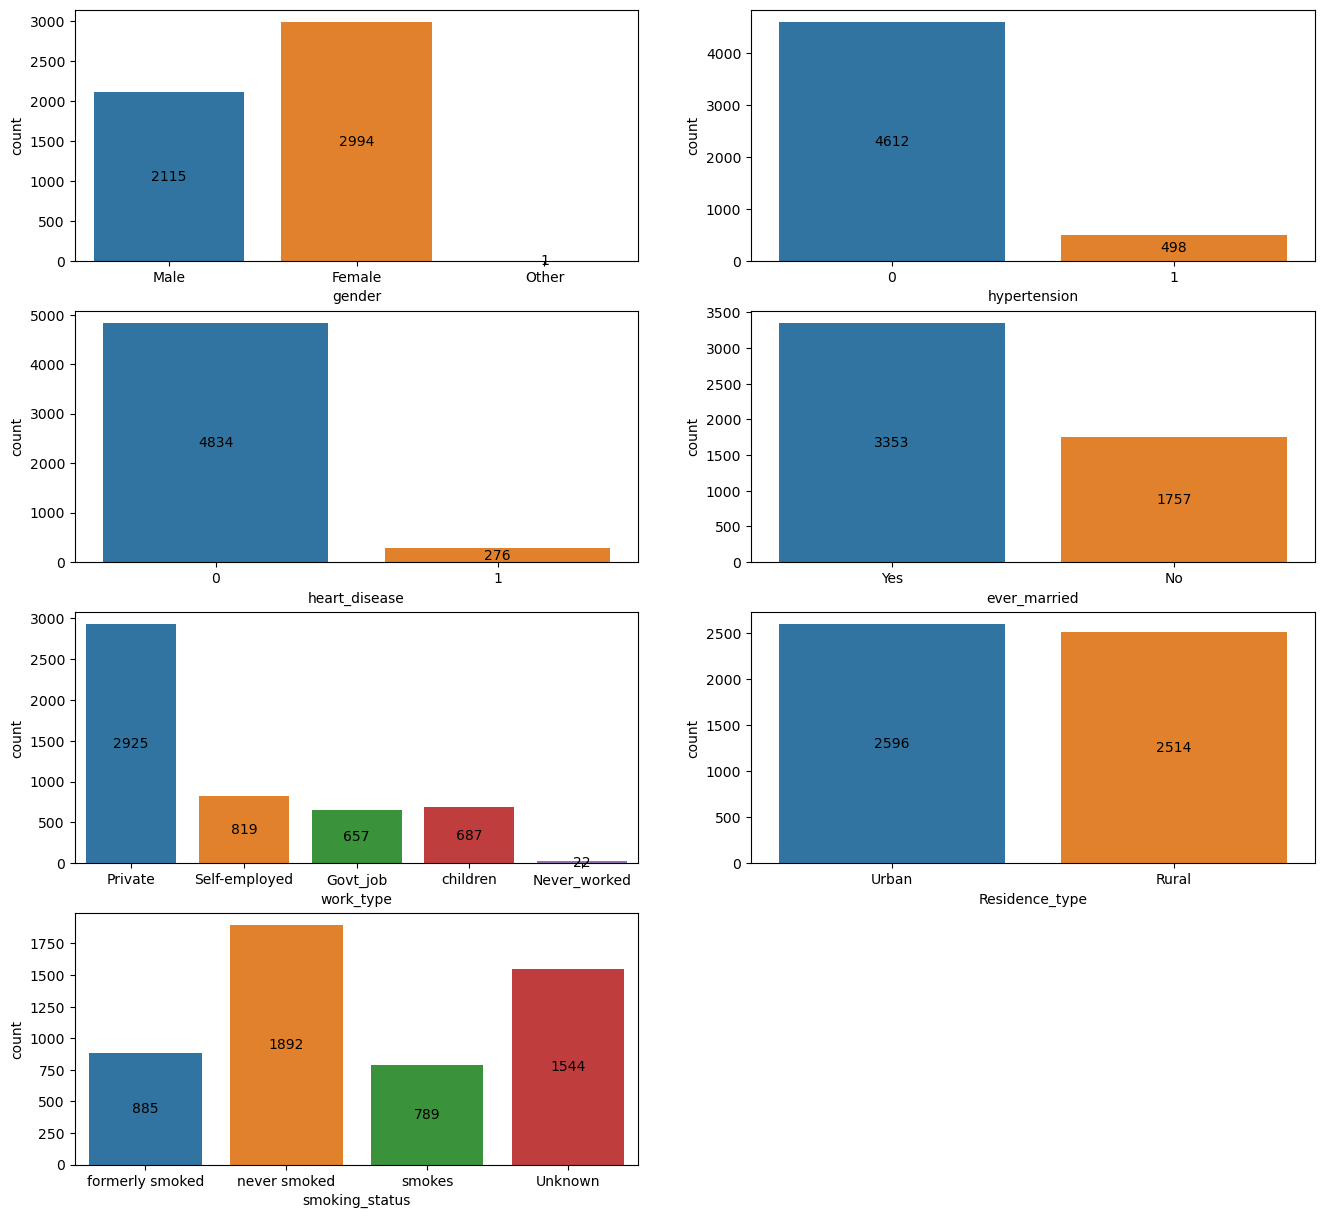

In [11]:
# Displaying distributions of categorial columns
categorical_cols = ["gender", "hypertension", "heart_disease", "ever_married", "work_type", "Residence_type", "smoking_status"]

fig = plt.figure(figsize=(16,15))

for idx, col in enumerate(categorical_cols):
    ax = plt.subplot(4, 2, idx+1)
    sns.countplot(x=stroke[col], ax=ax)
    # add data labels to each bar
    for container in ax.containers:
        ax.bar_label(container, label_type="center")

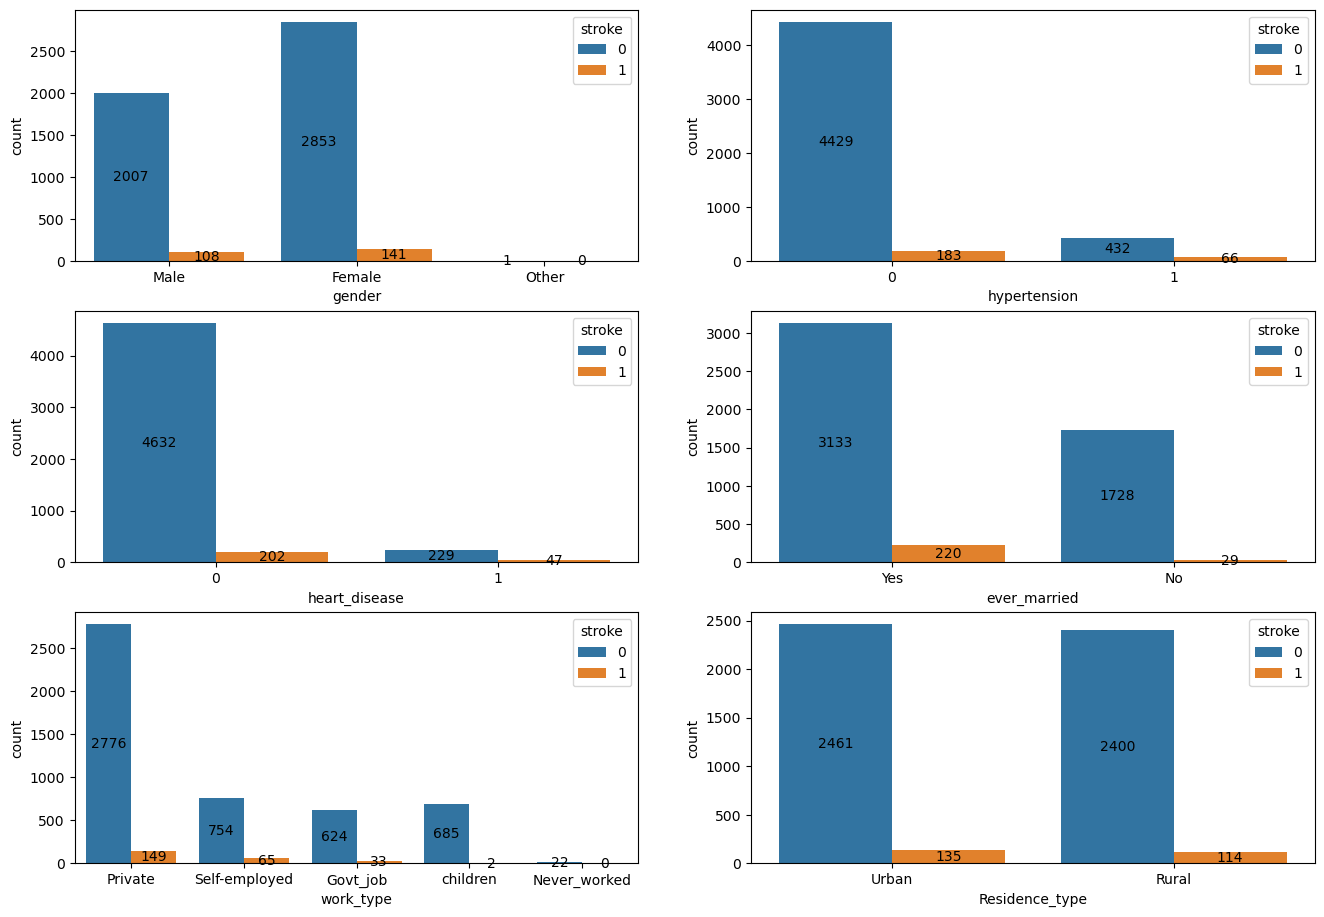

In [12]:
# Displaying the distributions with regard to stroke status
fig = plt.figure(figsize=(16,15))

for idx, col in enumerate(categorical_cols[:-1]):
    ax = plt.subplot(4, 2, idx+1)
    # group by HeartDisease
    sns.countplot(x=stroke[col], hue=stroke["stroke"], ax=ax)
    # add data labels to each bar
    for container in ax.containers:
        ax.bar_label(container, label_type="center")

In [13]:
stroke['gender'].value_counts()

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

As there is only 1 record of 'Other' gender, we will remove this observation from the dataset as this is more efficient than creating a completely new dummy column for it.

In [14]:
# Locate row we want to drop
i = stroke[((stroke.gender == 'Other'))].index
print(i)


Index([3116], dtype='int64')


In [15]:
# Remove row containing this value
stroke = stroke.drop(i, axis = 0)
stroke['gender'].value_counts()

gender
Female    2994
Male      2115
Name: count, dtype: int64

### Imputing missing values

In [16]:
stroke['bmi'].value_counts()

bmi
28.7    41
28.4    38
26.7    37
27.6    37
26.1    37
        ..
48.7     1
49.2     1
51.0     1
49.4     1
14.9     1
Name: count, Length: 418, dtype: int64

In [17]:
stroke['bmi'].isna().sum()

201

In [19]:
# Replacing missing bmi values with the mean of the column
stroke['bmi'].fillna(stroke['bmi'].mean(), inplace = True)
stroke['bmi'].isna().sum()

0

<Axes: >

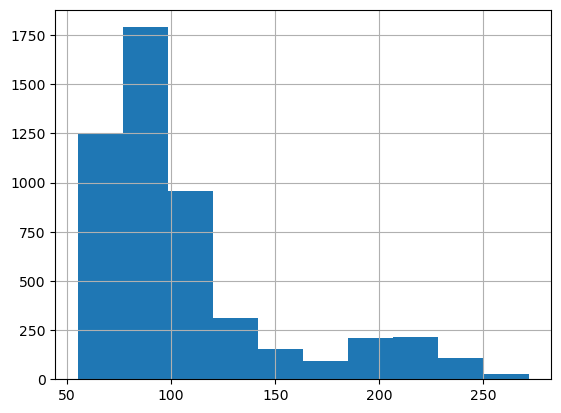

In [20]:
stroke['avg_glucose_level'].hist()

<Axes: >

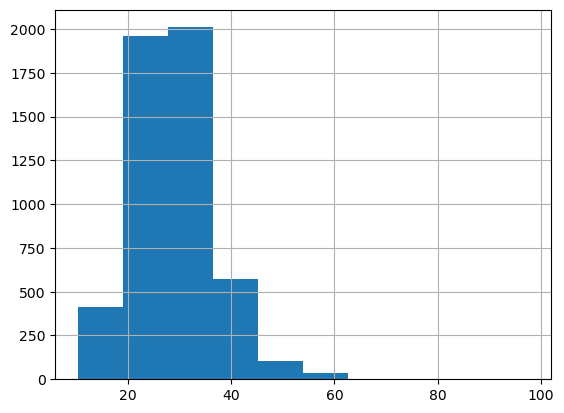

In [21]:
stroke['bmi'].hist()

In [22]:
stroke.skew(numeric_only = True)

id                  -0.019527
age                 -0.137430
hypertension         2.715026
heart_disease        3.946786
avg_glucose_level    1.572815
bmi                  1.076438
stroke               4.192807
dtype: float64

The only columns with very high skew values are stroke and heart_disease, but this is due to the rare nature of these being present in the dataset rather than there being outliers in these columns.

### More data cleaning

We will first remove the `id` column from the dataset as this does not give us any predictive power with regards to the `stroke` column.

In [23]:
stroke = stroke.drop('id', axis = 1)

We will also remove `work_type` and `Residence_type` as these don't seem to be relevant to the `stroke` column.

In [24]:
stroke_clean = stroke.drop(['work_type', 'Residence_type'], axis = 1)
stroke_clean.head()                         

,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,228.69,36.60000,formerly smoked,1
1,Female,61.0,0,0,Yes,202.21,28.89456,never smoked,1
2,Male,80.0,0,1,Yes,105.92,32.50000,never smoked,1
3,Female,49.0,0,0,Yes,171.23,34.40000,smokes,1
4,Female,79.0,1,0,Yes,174.12,24.00000,never smoked,1


In [25]:
# Changing smoking column to a binary column
stroke_clean['smoking_status'] = stroke_clean['smoking_status'].apply(lambda x: 1 if x in ['smokes', 'formerly smoked'] else 0)

In [26]:
# Change categorical columns to numeric
stroke_clean = pd.get_dummies(stroke_clean, drop_first = True)
stroke_clean.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,stroke,gender_Male,ever_married_Yes
0,67.0,0,1,228.69,36.60000,1,1,True,True
1,61.0,0,0,202.21,28.89456,0,1,False,True
2,80.0,0,1,105.92,32.50000,0,1,True,True
3,49.0,0,0,171.23,34.40000,1,1,False,True
4,79.0,1,0,174.12,24.00000,0,1,False,True


<Axes: >

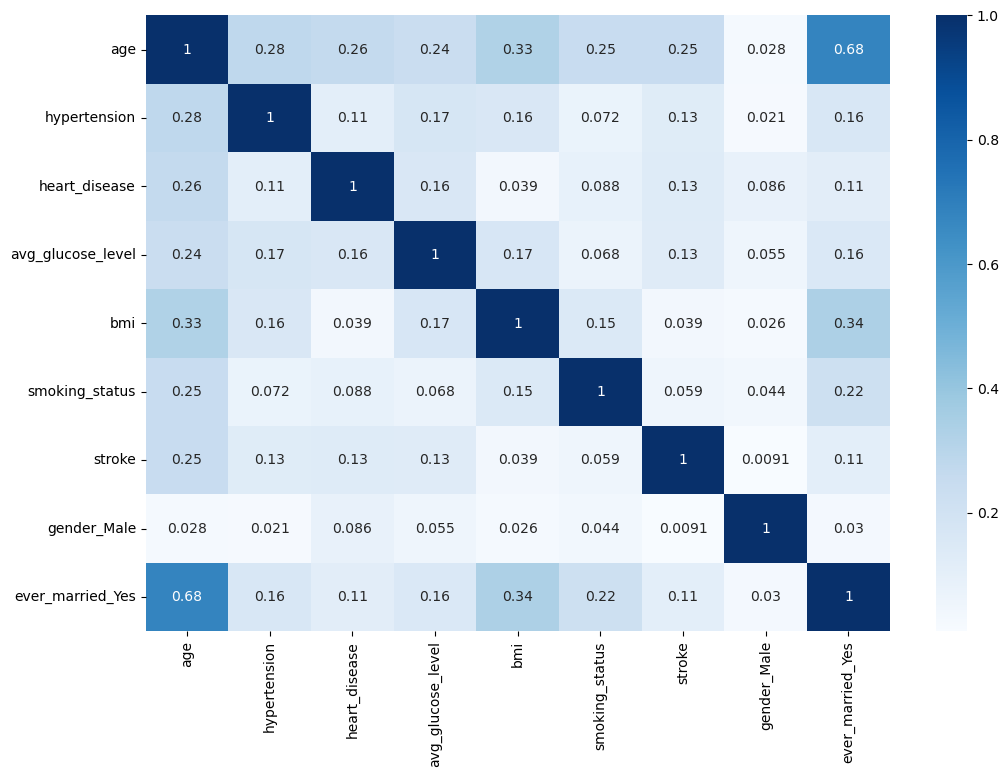

In [27]:
# Display correlations between columns
correlations = abs(stroke_clean.corr())
plt.figure(figsize=(12,8))
sns.heatmap(correlations, annot=True, cmap="Blues")

The highest correlations with our target value`stroke`seem to be `age`, `hypertension`, `heart_disease`, `avg_glucose_level`. This suggests these would be good columns to use as predictors in our models.

## Building the models

In [30]:
# Creating predictor and target variables and splitting into train and test sets
X = stroke_clean[["age", "hypertension", "heart_disease", "avg_glucose_level", "bmi", "smoking_status"]]
y = stroke_clean["stroke"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 133)
from sklearn.preprocessing import StandardScaler


In [31]:
# Checking for separation in the datasets
print("Y_train: ", sum(y_train == 0))
print("Y_train: ", sum(y_train == 1))
print("Y_test: ", sum(y_test == 0))
print("Y_test: ", sum(y_test == 1))

Y_train:  3901
Y_train:  186
Y_test:  959
Y_test:  63


## Logistic Regression

The first model we will implement is a logistic regression model to try and predict stroke values.

In [32]:
lr_model  = LogisticRegression(max_iter = 500)
lr_model.fit(X_train, y_train)

LogisticRegression(max_iter=500)

In [67]:
# Checking the various metrics for the model
accuracy = lr_model.score(X_train, y_train)

predictions = lr_model.predict(X_train)
tp = sum((predictions == 1) & (y_train == 1))
fp = sum((predictions == 1) & (y_train == 0))
tn = sum((predictions == 0) & (y_train == 0))
fn = sum((predictions == 0) & (y_train == 1))
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Training Accuracy: ", accuracy)

Training Accuracy:  0.9544898458527037


We see an initial training accuracy of 95% on the training data, which shows our model is accurately predicting stroke classifications to a high level.

In [66]:

# Checking the various metrics for the model (test set)
acc = lr_model.score(X_test, y_test)


print("Test Accuracy: ", acc)

Test Accuracy:  0.9383561643835616


There is a slightly lower accuracy score on the test set but it is still a very good value.

## KNN Classifier

We will now build a KNN Classifier model and compare accuracy ratings. We will start with creating a model for each of the features we are using and evaluate their performance using accuracy as a metric.

In [36]:
features = [
    "age", "hypertension", "heart_disease", "avg_glucose_level", "bmi", "smoking_status"
]
from sklearn.neighbors import KNeighborsClassifier
for feature in features:
    knn = KNeighborsClassifier(n_neighbors = 3)
    knn.fit(X_train[[feature]], y_train)
    accuracy = knn.score(X_train[[feature]], y_train)
    print(f"The k-NN classifier trained on {feature} and with k = 3 has an accuracy of {accuracy*100:.2f}%")

The k-NN classifier trained on age and with k = 3 has an accuracy of 94.57%
The k-NN classifier trained on hypertension and with k = 3 has an accuracy of 95.45%
The k-NN classifier trained on heart_disease and with k = 3 has an accuracy of 95.45%
The k-NN classifier trained on avg_glucose_level and with k = 3 has an accuracy of 95.62%
The k-NN classifier trained on bmi and with k = 3 has an accuracy of 95.16%
The k-NN classifier trained on smoking_status and with k = 3 has an accuracy of 95.45%


The best performing model was with the classifier trained on the `avg_glucose_level`, which we saw had a 0.13 correlation with `stroke`.

In [37]:
# Scaling the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])
X_test_scaled = scaler.transform(X_test[features])

In [40]:
# KNN model using all the features
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train_scaled, y_train)
accuracy = knn.score(X_test_scaled, y_test)
print(f"Accuracy: {accuracy*100:.2f}")

Accuracy: 92.47


We see a good accuracy score of 92% using 3 knn neighbours but we will see if we can improve this by searching for optimal parameters using Grid Search.

In [41]:
from sklearn.model_selection import GridSearchCV

grid_params = {"n_neighbors": range(1, 20),
                "metric": ["minkowski", "manhattan"]
              }

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, grid_params, scoring ='accuracy')
knn_grid.fit(X_train_scaled, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['minkowski', 'manhattan'],
                         'n_neighbors': range(1, 20)},
             scoring='accuracy')

In [42]:
knn_grid.best_score_*100, knn_grid.best_params_

(95.44900090677025, {'metric': 'minkowski', 'n_neighbors': 12})

We see we obtain an accuracy score of 95% using the minkowski metric and 12 neighbours. We will use these parameters to evaluate the test set.

In [43]:
from sklearn.metrics import accuracy_score
X_test_scaled = scaler.transform(X_test[features])
predictions = knn_grid.best_estimator_.predict(X_test_scaled)
accuracy = accuracy_score(y_test, predictions)
print(f" Model Accuracy on test set: {accuracy*100:.2f}")

 Model Accuracy on test set: 93.84


We get a 93.84% accuracy on the test set, which is about the same as the logistic regression model.

## LinearSVC model

In [54]:
from sklearn.svm import LinearSVC
svc = LinearSVC(penalty = 'l2', loss = 'squared_hinge', C = 10, random_state = 133, dual = True, max_iter = 100)
svc.fit(X_train, y_train)

/Users/chris/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=10, dual=True, max_iter=100, random_state=133)

In [55]:
#SVC score on test dataset
svc.score(X_test, y_test)

0.9383561643835616

## Classification Decision Tree

In [44]:
# Importing required libraries

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

In [45]:
tree = DecisionTreeClassifier(max_depth = 3, random_state = 133)

tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=133)

In [46]:
y_pred = tree.predict(X_test)

In [47]:
# Accuracy on test set
print("Accuracy:", round(accuracy_score(y_test,y_pred), 2))

Accuracy: 0.94


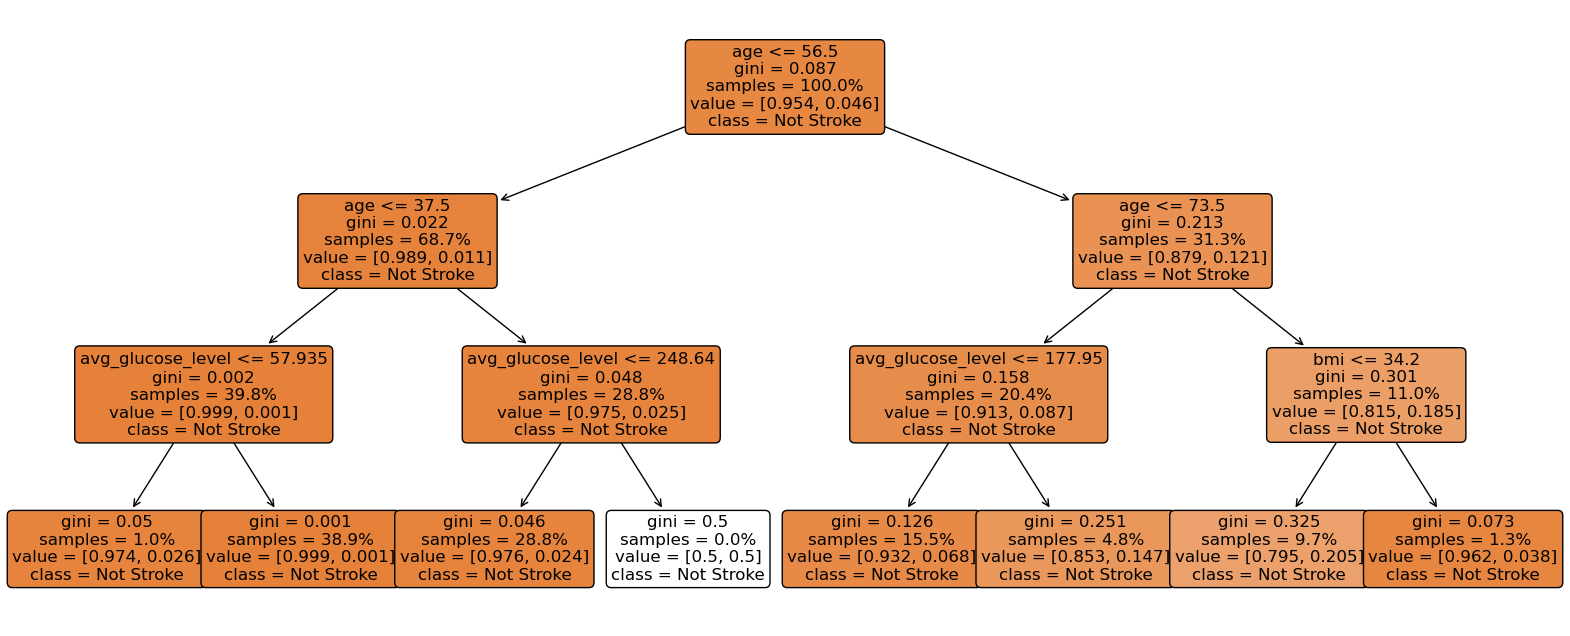

In [48]:
plt.figure(figsize = [20.0, 8.0])

# Plotting the tree with some specific parameters

_ = plot_tree(tree, 
              feature_names = X.columns.tolist(), 
              class_names = ["Not Stroke", "Stroke"],
              filled = True, 
              rounded = True, 
              proportion = True, 
              fontsize = 12) 

In [63]:
print("Accuracy:", round(tree.score(X_test, y_test), 2))

Accuracy: 0.94


In [68]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree, X, y, cv = 10)

print("Cross Validation Accuracy Scores:", scores.round(2)) 

Cross Validation Accuracy Scores: [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.95]


In [70]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(
                                oob_score = True,                                  
                                random_state = 24
                               )

forest.fit(X_train, y_train)

y_pred_forest = forest.predict(X_test)

print("Accuracy:", round(accuracy_score(y_test,y_pred_forest), 2))

Accuracy: 0.94


In [71]:
print("Out Of Bag Score:", round(forest.oob_score_, 2))

Out Of Bag Score: 0.95


## TensorFlow

Lastly, we will implement a Deep Learning model using the SequentialAPI from Keras.

In [73]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# define model
tf.random.set_seed(100)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(32, input_shape = (X_train.shape[1],), activation = 'relu'))
model.add(tf.keras.layers.Dense(16, activation= 'relu'))
model.add(tf.keras.layers.Dense(8, activation= 'relu'))
model.add(tf.keras.layers.Dense(4, activation= 'relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  

In [75]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [76]:
 print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 32)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 929 (3.63 KB)

 Trainable params: 929 (3.63 KB)

 Non-trainable params: 0 (0.00 B)

None


In [77]:
model.fit(X_train, y_train, epochs = 150)

Epoch 1/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8318 - loss: 0.6898
Epoch 2/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9514 - loss: 0.2233
Epoch 3/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9520 - loss: 0.1917
Epoch 4/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9521 - loss: 0.1817
Epoch 5/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9520 - loss: 0.1780
Epoch 6/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9515 - loss: 0.1756
Epoch 7/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9510 - loss: 0.1745
Epoch 8/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9511 - loss: 0.1737
Epoch 9/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9510 - loss: 0.1722
Epoch 10/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9513 - loss: 0.1718
Epoch 11/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9515 - loss: 0.1712
Epoch 12/150
128/128 ━━━━━━━━━━━━━━━━━━━━

We see that the accuracy and loss both improved over 150 epochs.

In [78]:
model.evaluate(X_train, y_train)

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9608 - loss: 0.1332


[0.14801041781902313, 0.9544898271560669]

(96% accuracy on the training set

In [79]:
model.evaluate(X_test, y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9376 - loss: 0.2157 


[0.20238828659057617, 0.9383561611175537]

94% accuracy on the test set.

## Conclusions

All of the models had around 95% accuracy on the training set and 94% accuracy on the test set. This was only an initial look at implementing classification models but given how high these accuracies are, it may be better to choose a dataset that is harder to predict in order to have more variation in accuracy values and more sensitivity to hyperparameter tuning and feature selection.